# This baseline code requires a GPU device. If you have not selected the GPU runtime type, you can change the runtime type to enable GPU.

In [ ]:
import os
import random
import time
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

# Python package for pre-processing 
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensor

# Python package for visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('Pytorch version: {}'.format(torch.__version__))
print('Is GPU available: {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu" 

print('CPU count: {}'.format(os.cpu_count()))  # 2

Pytorch version: 1.8.1+cu101
Is GPU available: True
Tesla V100-SXM2-16GB
The number of GPUs available: 1
CPU count: 2


# Prepare data

In [ ]:
!wget https://www.dropbox.com/s/avorjdz8332stux/coding_test2_data.tar
!tar -xf coding_test2_data.tar
!rm coding_test2_data.tar

--2021-04-21 11:48:51--  https://www.dropbox.com/s/avorjdz8332stux/coding_test2_data.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/avorjdz8332stux/coding_test2_data.tar [following]
--2021-04-21 11:48:52--  https://www.dropbox.com/s/raw/avorjdz8332stux/coding_test2_data.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee1a76cc400aac484213b32262.dl.dropboxusercontent.com/cd/0/inline/BNBIwlMRsKQxcl-CTFGktpW_nxPZmtqRV7Xxaps1m8gNgAvJ6nZcZ6dxzF9OVZo-i1vxZbqSWbqWn3VW0pMhPIgbiyfGyPtE6IGYV1e2Kyltjyv-dV98fC6O7RW0NJiQ6WhqMCLQrcA8l5QPFY4-jUEN/file# [following]
--2021-04-21 11:48:52--  https://ucee1a76cc400aac484213b32262.dl.dropboxusercontent.com/cd/0/inline/BNBIwlMRsKQxcl-CTFGktpW_nxPZmtqRV7Xxaps1m8gNgAvJ6nZcZ6dxzF9O

# Set the hyperparameters and fix the seed

In [ ]:
batch_size = 8   # Mini-batch size
num_epochs = 1
learning_rate = 1e-04

In [ ]:
# fix the seed
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA of the training data

In [ ]:
%matplotlib inline

dataset_path = 'input'
anns_file_path = os.path.join(dataset_path, 'train.json')

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


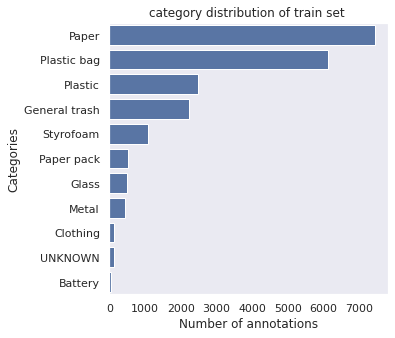

In [ ]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [ ]:
sorted_temp_df = df.sort_index()
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


# Make a CustomDataset class

In [ ]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataset(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # Get the image_info using coco library
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # Load the image using opencv
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            # print("image_infos['id'] : {}".format(image_infos['id']) )
            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks_size : height x width            
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Background = 0, Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # We can use Albumentations for image & mask transformation(or augmentation)
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
                masks =  masks.squeeze()
            
            return images, masks, image_infos
        
        if self.mode == 'test':            
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

# Create instances of CustomDataset and Assign it to DataLoader

In [ ]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = os.path.join(dataset_path, 'train.json')
val_path = os.path.join(dataset_path, 'val.json')
test_path = os.path.join(dataset_path, 'test.json')

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([    
    ToTensor(),
])

val_transform = A.Compose([    
    ToTensor(),
])

test_transform = A.Compose([    
    ToTensor(),
])

# create own Dataset 2
# train dataset
train_dataset = CustomDataset(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataset(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataset(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=1,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.30s)
creating index...
index created!
loading annotations into memory...
Done (t=1.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Show a sample by dataloader

### train_loader
This train_loader loads the data for training.

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}, {9, 'Plastic bag'}]


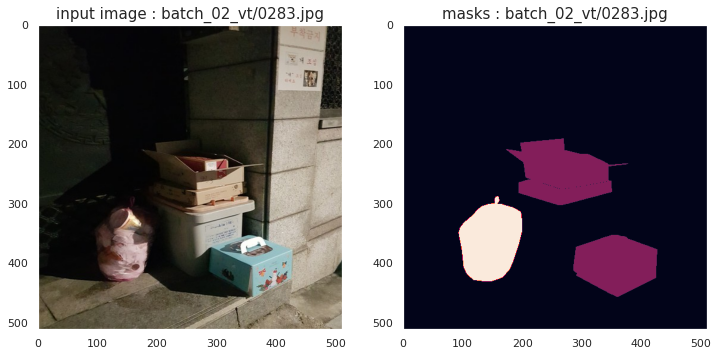

In [ ]:
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

### valid_loader
This valid_loader loads the data for validation.
We can use this validation set to check our current model performance.

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Plastic', 7}, {9, 'Plastic bag'}]


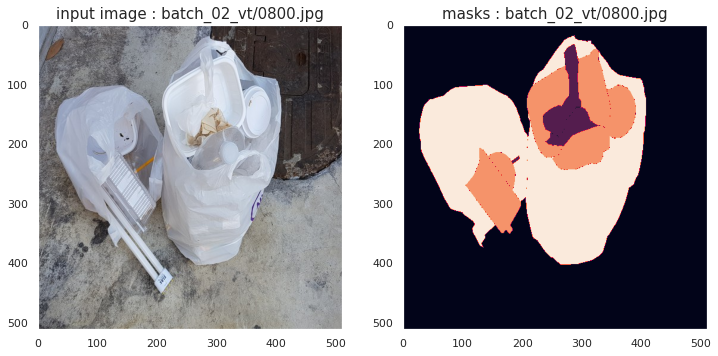

In [ ]:
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs    
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

### test_loader
This test_loader loads a data for test which is used to calculate the score of the leaderboard.

Note that we can't show the mask image because the mask image in the test set is target we will predict.

image shape: [3, 512, 512]


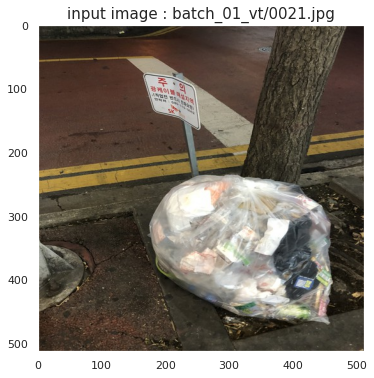

In [ ]:
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    # temp_masks = masks
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

# Baseline model
- Here, we show you the UNet with EfficientNet-B0 encoder model. 
- We just built this baseline model with using a small model, no image augmentation, no fine-tuned hyper-parameters, etc.
- you can build your model based on this baseline model and you can improve the model in your own way.

In [ ]:
# jupyter command 에서 library download
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

# model 불러오기
# 출력 레이블 수 정의 (classes = 12)
model = smp.Unet(encoder_name='efficientnet-b0', classes=12 , encoder_weights="imagenet", activation=None)
model = model.to(device)

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xovvhz6n
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xovvhz6n
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 245kB 19.9MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-cp37-none-any.whl size=83164 sha256=03bbcff89cbc325614674457574e990545587b6c20b06b392168d95aa7d0ca6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fb_n49hp/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=83655e5b713a4c46910137ef10b9458210136984a2605d7d5e475b1a6146fd5a
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-no

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


# Define the train, validation, test functions

In [ ]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            images, masks = images.to(device), masks.to(device)                  
            
            outputs = model(images)
            
            # compute the loss
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print the loss at 25 step intervals.
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # print the loss and save the best model at val_every intervals.
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))

    return avrg_loss

In [ ]:
# define the evaluation function
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/utils.py
import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

# Define the function to save the model

In [ ]:
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='best_model.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

# Create instances of loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

# Train

In [ ]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/1], Step [25/328], Loss: 2.4095
Epoch [1/1], Step [50/328], Loss: 2.1066
Epoch [1/1], Step [75/328], Loss: 1.8644
Epoch [1/1], Step [100/328], Loss: 1.6223
Epoch [1/1], Step [125/328], Loss: 1.2552
Epoch [1/1], Step [150/328], Loss: 1.0766
Epoch [1/1], Step [175/328], Loss: 1.0089
Epoch [1/1], Step [200/328], Loss: 0.9618
Epoch [1/1], Step [225/328], Loss: 1.0467
Epoch [1/1], Step [250/328], Loss: 0.7559
Epoch [1/1], Step [275/328], Loss: 0.7299
Epoch [1/1], Step [300/328], Loss: 0.8978
Epoch [1/1], Step [325/328], Loss: 0.6047
Start validation #1
Validation #1  Average Loss: 0.6594, mIoU: 0.1932
Best performance at epoch: 1
Save model in ./saved


# Load the saved model 

In [ ]:
import segmentation_models_pytorch as smp

# path of saved best model
model_path = './saved/best_model.pt'

# initialize the model
model = smp.Unet(encoder_name='efficientnet-b0', classes=12 , encoder_weights=None, activation=None).to(device)

# load the saved best model
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

# switch to evaluation mode
model.eval()
print('')

 # Inference
 Infer one sample and show the our model prediction result to make sure our model works correctly.

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}, {9, 'Plastic bag'}]


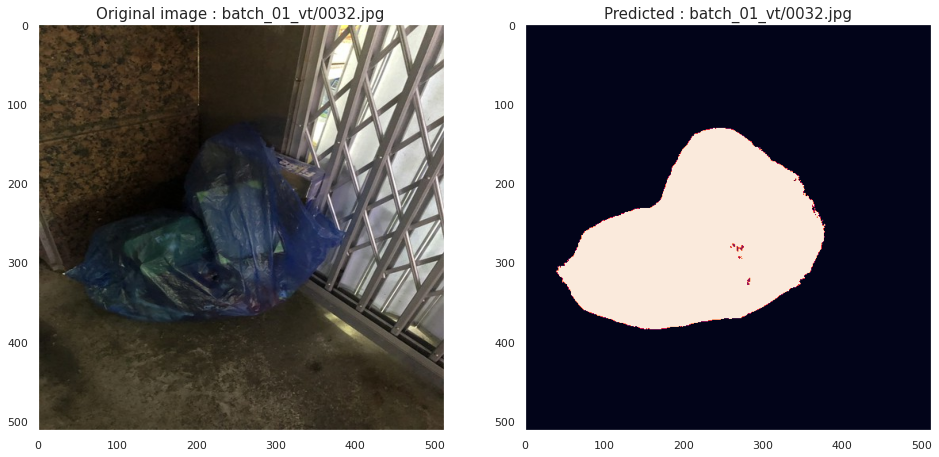

In [ ]:
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted mask
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

# Define the test function to submit model prediction

In [ ]:
def test(model, data_loader, device):
    size = 512    
    print('Start prediction.')
    model.eval()

    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv(os.path.join(dataset_path, 'sample_submission.csv'), index_col=None)

# Make a submission

In [ ]:
submission = pd.read_csv(os.path.join(dataset_path, 'sample_submission.csv'), index_col=None)

# inference
file_names, preds = test(model, test_loader, device)

for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# save submission.csv
submission.to_csv("submission.csv", index=False)

Start prediction.
End prediction.
